# Model Evaluation: Random Forest and XGBoost

Following the development of new features and the implementation of a backtesting (walk-forward), we proceed to evaluate two ensemble learning models: **Random Forest** and **XGBoost**.

These algorithms were chosen based on their strong performance in handling non-linear relationships, robustness to noise, and effectiveness in capturing complex interactions between features. Research was also done on which we found that different financial prediction models tend to use Random Forest to predict market swings such as up and down.

The objective of this evaluation is to identify which model provides more consistent and reliable predictions for price movement classification tasks.

This section will detail the model configurations, training methodology, evaluation metrics, and performance comparison across multiple time horizons.


In [19]:
## loading data
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, accuracy_score, recall_score
import time
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

df = pd.read_csv("../data/2019-2023_stock_with_features_dif_tickers.csv")

# Pre-selected features for modeling
features = ['quantity', 'volume', 'ibovespa_close', 'day_of_week', 'price_range', 'volume_per_quantity',
            'rolling_std_5', 'rolling_return_5', 'momentum_5', 'rolling_volume_5', 'Trend_2',
            'Close_Ratio_5', 'Trend_5', 'Close_Ratio_55', 'Trend_55', 'Close_Ratio_220']
df

,date,ticker,quantity,volume,ibovespa_close,day_of_week,price_range,volume_per_quantity,tomorrow,target,rolling_std_5,rolling_return_5,rolling_volume_5,momentum_5,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_55,Trend_55,Close_Ratio_220
0,2019-11-18,ABEV3,9445200,165711710.0,106347.0,1,0.26,17.544542,17.67,1,0.091815,0.001866,246297201.6,0.008848,2.0,1.005843,3.0,0.946900,27.0,0.971916
1,2019-11-18,B3SA3,10101700,501185409.0,106347.0,1,1.54,49.613967,47.94,0,0.542015,0.007892,394530554.4,-0.008612,1.0,0.990027,3.0,1.066652,34.0,1.284061
2,2019-11-18,BBAS3,15585600,724962222.0,106347.0,1,1.15,46.514874,45.79,0,0.494803,-0.001119,641216796.2,-0.014652,1.0,0.989588,2.0,0.987510,26.0,0.933396
3,2019-11-18,BBDC4,18808900,625495829.0,106347.0,1,0.91,33.255312,33.07,0,0.394373,-0.005110,597208475.0,-0.020286,0.0,0.986188,0.0,0.970354,27.0,0.886461
4,2019-11-18,BRAP4,1248000,40441499.0,106347.0,1,0.78,32.405047,32.69,1,0.455379,-0.001457,46990409.6,-0.002218,2.0,1.002414,3.0,1.032162,32.0,1.047033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28982,2023-11-17,ITUB4,24575400,748326813.0,125062.0,5,0.47,30.450239,NaN,0,0.419786,0.005742,882559210.0,0.026220,2.0,1.017918,4.0,1.101164,28.0,1.139022
28983,2023-11-17,MGLU3,297371000,659930643.0,125062.0,5,0.21,2.219217,NaN,0,0.199675,0.061008,503911766.0,0.207835,2.0,1.144330,4.0,1.089887,19.0,0.709667
28984,2023-11-17,GGBR4,12991400,319205611.0,125062.0,5,0.45,24.570532,NaN,0,0.610066,0.011093,329996779.2,0.034788,2.0,1.019381,4.0,1.034852,26.0,0.936003
28985,2023-11-17,WEGE3,8938000,296624415.0,125062.0,5,0.82,33.186889,NaN,0,0.470606,0.004170,266163011.2,0.006415,1.0,1.001264,3.0,0.959653,22.0,0.883089


In [22]:
# helpers for predictions
def evaluate_preds(y_true, y_pred, label="Evaluation"):
    """
    Compute and print Accuracy, Precision, Recall metrics.
    """
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    print(f"\n=== {label} Metrics ===")
    print("Accuracy:", round(acc, 4))
    print("Precision:", round(prec, 4))
    print("Recall:", round(rec, 4))
    return acc, prec, rec

def predict(train, test, predictors, model, threshold=0.6):
    """
    Train model on train data, predict probabilities on test data,
    then convert probabilities to binary predictions with given threshold.
    """
    model.fit(train[predictors], train['target'])
    probs = model.predict_proba(test[predictors])[:, 1]
    preds = (probs >= threshold).astype(int)
    return pd.DataFrame({'target': test['target'], 'Predictions': preds}, index=test.index)

def backtest_stepwise(df, model, features, start=2000, step=1500, threshold=0.6):
    """
    Stepwise backtesting: train on increasing dataset slices, test on next slice.
    Calculates train/test precision and overfit ratio at each step.
    """
    all_preds = []
    train_precisions = []
    test_precisions = []
    overfit_ratios = []
    total_steps = (df.shape[0] - start) // step + 1
    start_time = time.time()

    for i, idx in enumerate(range(start, df.shape[0], step), 1):
        train = df.iloc[:idx].copy()
        test = df.iloc[idx:idx + step].copy()

        # Predict on test
        preds = predict(train, test, features, model, threshold)
        all_preds.append(preds)

        # Predict on train
        train_probs = model.predict_proba(train[features])[:, 1]
        train_preds = (train_probs >= threshold).astype(int)

        # Compute precision
        train_prec = precision_score(train['target'], train_preds)
        test_prec = precision_score(test['target'], preds['Predictions'])
        train_precisions.append(train_prec)
        test_precisions.append(test_prec)

        # Compute overfit ratio for this step
        overfit_ratio = train_prec / test_prec if test_prec > 0 else float('nan')
        overfit_ratios.append(overfit_ratio)
        print(f"Step {i}/{total_steps} | Train Prec: {train_prec:.3f} | Test Prec: {test_prec:.3f} | Overfit Ratio: {overfit_ratio:.3f}")

        # ETA info
        elapsed = time.time() - start_time
        eta = (total_steps - i) * (elapsed / i)
        print(f"Elapsed: {elapsed:.1f}s, ETA: {eta/60:.1f} min\n")

    # Average over all steps
    avg_train_prec = sum(train_precisions) / len(train_precisions)
    avg_test_prec = sum(test_precisions) / len(test_precisions)
    avg_overfit_ratio = sum([r for r in overfit_ratios if not pd.isna(r)]) / len([r for r in overfit_ratios if not pd.isna(r)])

    print(f"\nAverage Train Precision: {avg_train_prec:.3f}")
    print(f"Average Test Precision:  {avg_test_prec:.3f}")
    print(f"Average Overfit Ratio:   {avg_overfit_ratio:.3f}")

    # Combine all predictions and store attributes
    preds_df = pd.concat(all_preds)
    preds_df.attrs['train_precision'] = avg_train_prec
    preds_df.attrs['test_precision'] = avg_test_prec
    preds_df.attrs['overfit_ratio'] = avg_overfit_ratio

    return preds_df



In [23]:
# Define your models
models = [
    RandomForestClassifier(
        n_estimators=200, min_samples_split=50, n_jobs=-1, random_state=1
    ),
    XGBClassifier(
        n_estimators=200,
        max_depth=3,
        learning_rate=0.05,
        gamma=0.3,
        reg_alpha=2,
        reg_lambda=8,
        tree_method='hist',
        random_state=1
    )
]

# Optional: names for printing
model_names = ["Random Forest", "XGBoost"]

# Dictionary to store results
all_results = {}

for name, model in zip(model_names, models):
    print(f"\n\n===== Running Backtest for {name} =====\n")

    # Run stepwise backtest
    predictions = backtest_stepwise(df, model, features)

    # Evaluate overall predictions
    acc, prec, rec = evaluate_preds(predictions['target'], predictions['Predictions'], label=f"{name} Overall Backtest")

    # Print prediction distribution
    print("\nPrediction Distribution:")
    print(predictions['Predictions'].value_counts())

    print("\nActual Distribution:")
    print(predictions['target'].value_counts(normalize=True))

    # Store results
    all_results[name] = {
        "predictions": predictions,
        "accuracy": acc,
        "precision": prec,
        "recall": rec
    }




===== Running Backtest for Random Forest =====

Step 1/18 | Train Prec: 0.976 | Test Prec: 0.495 | Overfit Ratio: 1.973
Elapsed: 0.2s, ETA: 0.1 min

Step 2/18 | Train Prec: 0.978 | Test Prec: 0.617 | Overfit Ratio: 1.584
Elapsed: 0.5s, ETA: 0.1 min

Step 3/18 | Train Prec: 0.982 | Test Prec: 0.493 | Overfit Ratio: 1.993
Elapsed: 0.9s, ETA: 0.1 min

Step 4/18 | Train Prec: 0.984 | Test Prec: 0.469 | Overfit Ratio: 2.098
Elapsed: 1.4s, ETA: 0.1 min

Step 5/18 | Train Prec: 0.991 | Test Prec: 0.860 | Overfit Ratio: 1.151
Elapsed: 2.1s, ETA: 0.1 min

Step 6/18 | Train Prec: 0.981 | Test Prec: 0.829 | Overfit Ratio: 1.183
Elapsed: 2.8s, ETA: 0.1 min

Step 7/18 | Train Prec: 0.963 | Test Prec: 0.631 | Overfit Ratio: 1.527
Elapsed: 3.4s, ETA: 0.1 min

Step 8/18 | Train Prec: 0.966 | Test Prec: 0.542 | Overfit Ratio: 1.782
Elapsed: 4.2s, ETA: 0.1 min

Step 9/18 | Train Prec: 0.970 | Test Prec: 0.569 | Overfit Ratio: 1.705
Elapsed: 5.2s, ETA: 0.1 min

Step 10/18 | Train Prec: 0.976 | Test Pre


=== Model Comparison Metrics ===
           Model  Accuracy  Precision    Recall  Train_Precision  \
0  Random Forest  0.568978   0.643758  0.273564         0.965431   
1        XGBoost  0.563753   0.630889  0.268810         0.789404   

   Test_Precision  Overfit_Ratio  Balanced_Score  
0        0.638781       1.511365        0.280825  
1        0.636793       1.239656        0.469034  


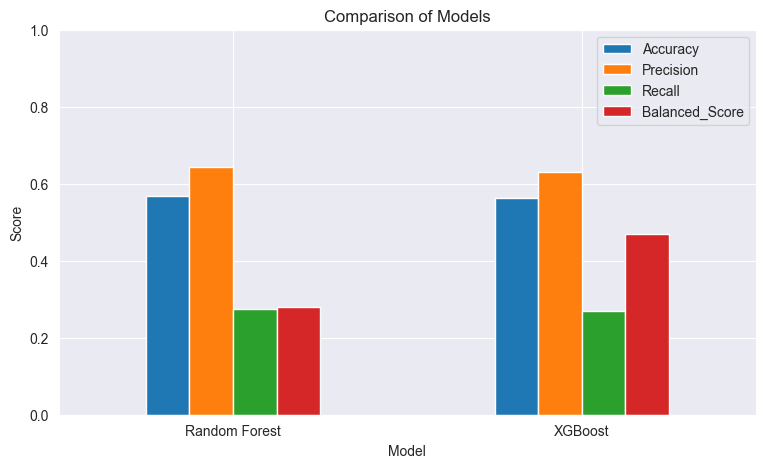

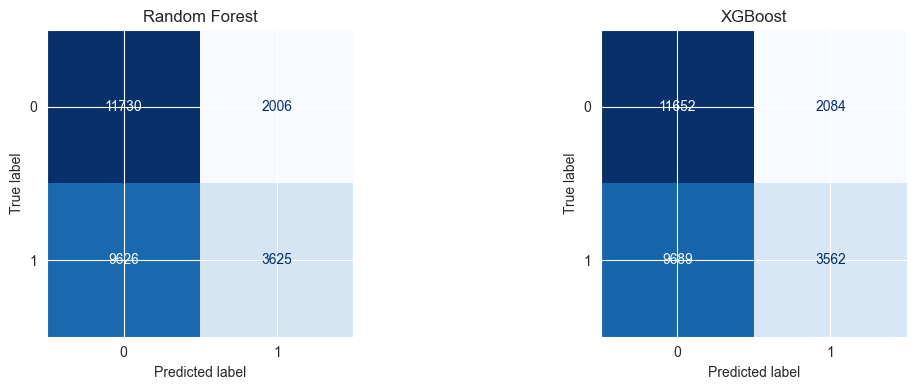

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# -----------------------------
# Compute metrics + balanced score
# -----------------------------
metrics_list = []

for name, res in all_results.items():
    y_true = res["predictions"]["target"]
    y_pred = res["predictions"]["Predictions"]

    acc = res["accuracy"]
    prec = res["precision"]
    rec = res["recall"]

    train_prec = res["predictions"].attrs.get("train_precision", None)
    test_prec = res["predictions"].attrs.get("test_precision", None)

    if train_prec and test_prec:
        overfit_ratio = train_prec / test_prec
        alpha = 0.7  # same as used before
        balanced_score = test_prec - alpha * (overfit_ratio - 1)
    else:
        overfit_ratio = None
        balanced_score = None

    metrics_list.append({
    "Model": name,
    "Accuracy": acc,
    "Precision": prec,
    "Recall": rec,
    "Train_Precision": train_prec,
    "Test_Precision": test_prec,
    "Overfit_Ratio": overfit_ratio,
    "Balanced_Score": balanced_score
    })


metrics_df = pd.DataFrame(metrics_list)
print("\n=== Model Comparison Metrics ===")
print(metrics_df)

# -----------------------------
# Bar plot for metrics comparison
# -----------------------------
metrics_df.plot(x="Model", y=["Accuracy","Precision","Recall","Balanced_Score"], kind="bar", figsize=(9,5), ylim=(0,1))
plt.title("Comparison of Models")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.show()

# -----------------------------
# Confusion matrices side by side
# -----------------------------
fig, axes = plt.subplots(1, len(all_results), figsize=(12,4))

for ax, (name, res) in zip(axes, all_results.items()):
    cm = confusion_matrix(res["predictions"]["target"], res["predictions"]["Predictions"])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot(ax=ax, cmap=plt.cm.Blues, colorbar=False)
    ax.set_title(name)

plt.tight_layout()
plt.show()


# Backtest Performance Analysis

## Overall Backtest Metrics
| Model             | Accuracy | Precision | Recall |
| ----------------- | -------- | --------- | ------ |
| **Random Forest** | 0.569    | 0.644     | 0.274  |
| **XGBoost**       | 0.564    | 0.631     | 0.269  |


The Random Forest and XGBoost models perform similarly in overall accuracy, both correctly predicting the market direction about 56–57% of the time. Precision remains in the low-to-mid 60% range, meaning when the models predict an upward movement, they are correct roughly two-thirds of the time.
However, both models exhibit low recall (27%), showing that they capture only a small portion of the actual upward movements.

---


## Overfitting and Model Selection

| Model             | Train Precision | Test Precision | Overfit Ratio | Balanced Score |
| ----------------- | --------------- | -------------- | ------------- | -------------- |
| **Random Forest** | 0.965           | 0.639          | 1.51          | 0.281          |
| **XGBoost**       | 0.789           | 0.637          | 1.24          | 0.469          |


The Random Forest model demonstrates a notable overfitting tendency, with a high overfit ratio of 1.51, meaning it performs about 51% better on training data than on unseen data.
In contrast, XGBoost achieves a much more balanced performance with an overfit ratio of 1.24, suggesting improved generalization across different backtest segments.

The Balanced Score (which penalizes overfitting) further highlights this: XGBoost attains a significantly higher score (0.47 vs. 0.28), indicating better trade-off between predictive precision and model robustness.

---

## Interpretation

When comparing Random Forest and XGBoost on our dataset, both models achieve very similar predictive performance, with comparable accuracy (56–57%), precision (63–64%), and recall (27%). However, overfitting is not taken into account with these metrics.

To evaluate which params were the best we created a balanced score metric, this metric aims to find the highest precision with the lowest overfitting ratio.

balanced_score = avg_test - alpha * (overfit_ratio - 1)

alpha is a weighting factor that controls how much we penalize overfitting. We aimed for an overfit ratio below 1.2 as that generally means the model is not overfitting too much.

We see that the XGBoost model has a significantly higher balanced score than the random forest, meaning that the random forest is overfitting and the other metrics are not accurate when compared to XGBoost.

XGBoost is the preferred model for multiple reasons:
- the key reason is the better balanced score which indicates that this model is overfitting much less than  the Random Forest model.
- it trains faster than Random Forest on the same dataset
- it provides more hyperparameters for fine-tuning, allowing for greater flexibility in optimising the model for precision, recall, or balanced performance.
Consequently, XGBoost was chosen as the final model for our analysis.

---
## Next Steps

To address overfitting, improve recall and overall predictive power, the next phase involves switching to **XGBoost**, which allows more granular hyperparameter tuning to control model complexity and better handle class imbalance.

We will also evaluate that we are not getting lucky with our time selection when it comes to our back test and validate it by testing different time splits (cross-validation).
